In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [2]:
# name of the CSV file from BAY
INPUT_CSV_FILE = 'data.csv'

# name of the CSV file generated from holiday information as input features
FACTORS_CSV_FILE = 'factors.csv'

# Number of the input rows (or days)
N_STEPS_IN = 30

# Day offset of the output
N_STEPS_OUT = 14

In [3]:
# predefined column header
RAW_DATA_COLUMNS = [
    'EFFECTIVE_DATE',
    'BRANCH_CODE',
    'BRANCH_NAME',
    'CASH_IN_AMT',
    'CASH_OUT_AMT',
    'CASH_IN_AMT_GT1M',
    'CASH_OUT_AMT_GT1M' ,
    'SHIPIN1K',
    'SHIPIN500',
    'SHIPIN100',
    'SHIPIN_OTHER',
    'SHIPOUT1K',
    'SHIPOUT500',
    'SHIPOUT100',
    'SHIPOUT_OTHER',
    'OUTSTANDING1K',
    'OUTSTANDING500',
    'OUTSTANDING100',
    'OUTSTANDING_OTHER'
]

# predefined day names (0 = MON, 1=TUE, ..., 6 = SUN)
WEEKDAY_NAMES = ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']

def read_raw_data_csv(input_filename):

    # read raw input data from csv files
    df = pd.read_csv(input_filename)

    # set the column names
    df.columns = RAW_DATA_COLUMNS

    # convert EFFECTIVE_DATE from 'YYYYMMDD' format to datetime object
    df['EFFECTIVE_DATE'] = pd.to_datetime(df['EFFECTIVE_DATE'].apply(str), format="%Y-%m-%d")

    # create column WEEKDAY_NAME
    df['WEEKDAY_NAME'] = df['EFFECTIVE_DATE'].dt.weekday.apply(lambda x: WEEKDAY_NAMES[x])

    # create columns TOTAL_* for further analysis
    df['TOTAL_CASH_IN'] = df['CASH_IN_AMT'] + df['CASH_IN_AMT_GT1M']
    df['TOTAL_CASH_OUT'] = df['CASH_OUT_AMT'] + df['CASH_OUT_AMT_GT1M']
    df['TOTAL_CASH_CHANGE'] = df['TOTAL_CASH_OUT'] - df['TOTAL_CASH_IN']
    df['TOTAL_SHIP_OUT'] = df['SHIPOUT1K'] + df['SHIPOUT500'] + df['SHIPOUT100'] + df['SHIPOUT_OTHER']
    df['TOTAL_OUTSTANDING'] = df['OUTSTANDING1K'] + df['OUTSTANDING500'] + df['OUTSTANDING100'] + df['OUTSTANDING_OTHER']

    # create column CASH_CHANGE_RANGE for further analysis
    df['CASH_CHANGE_RANGE'] = pd.cut(df['TOTAL_CASH_CHANGE'], bins=20, precision=0)

    return df

df = read_raw_data_csv(INPUT_CSV_FILE)
df.head()

,EFFECTIVE_DATE,BRANCH_CODE,BRANCH_NAME,CASH_IN_AMT,CASH_OUT_AMT,CASH_IN_AMT_GT1M,CASH_OUT_AMT_GT1M,SHIPIN1K,SHIPIN500,SHIPIN100,...,OUTSTANDING500,OUTSTANDING100,OUTSTANDING_OTHER,WEEKDAY_NAME,TOTAL_CASH_IN,TOTAL_CASH_OUT,TOTAL_CASH_CHANGE,TOTAL_SHIP_OUT,TOTAL_OUTSTANDING,CASH_CHANGE_RANGE
0,2018-01-01,A1,-,0.0,268860.5,0.0,0.0,0,0,0,...,5275500,2603400,1416498.25,MON,0.0,268860.5,268860.5,0,59462398.25,"(-12443909.0, 9836110.0]"
1,2018-01-01,A2,-,0.0,0.0,0.0,0.0,0,0,0,...,626500,178600,205022.25,MON,0.0,0.0,0.0,0,7476122.25,"(-12443909.0, 9836110.0]"
2,2018-01-01,A3,-,0.0,0.0,0.0,0.0,0,0,0,...,169500,183100,105759.25,MON,0.0,0.0,0.0,0,6391359.25,"(-12443909.0, 9836110.0]"
3,2018-01-01,A4,-,0.0,0.0,0.0,0.0,0,0,0,...,855000,619400,278853.25,MON,0.0,0.0,0.0,0,7686253.25,"(-12443909.0, 9836110.0]"
4,2018-01-01,B1,-,0.0,0.0,0.0,0.0,0,0,0,...,967000,465200,266163.00,MON,0.0,0.0,0.0,0,21018363.00,"(-12443909.0, 9836110.0]"


In [4]:
# predefined columns name
FACTOR_COLUMNS = [
    'EFFECTIVE_DATE',
    'DAY_OF_WEEK',
    'WEEKEND',
    'HOLIDAY',
    'WEEKEND_HOLIDAY'
]

def read_factors_csv(factor_filename):

    # read factors data from csv files
    df = pd.read_csv(factor_filename, header=None)

    # set the column names
    df.columns = FACTOR_COLUMNS
    
    # convert EFFECTIVE_DATE from 'YYYYMMDD' format to datetime object
    df['EFFECTIVE_DATE'] = pd.to_datetime(df['EFFECTIVE_DATE'].apply(str))
    
    # encode DAY_OF_WEEK column with one hot encoding
    df['IS_SUN'] = (df['DAY_OF_WEEK'] == 1).astype(int)
    df['IS_MON'] = (df['DAY_OF_WEEK'] == 2).astype(int)
    df['IS_TUE'] = (df['DAY_OF_WEEK'] == 3).astype(int)
    df['IS_WED'] = (df['DAY_OF_WEEK'] == 4).astype(int)
    df['IS_THU'] = (df['DAY_OF_WEEK'] == 5).astype(int)
    df['IS_FRI'] = (df['DAY_OF_WEEK'] == 6).astype(int)
    df['IS_SAT'] = (df['DAY_OF_WEEK'] == 7).astype(int)

    return df

df_factors = read_factors_csv(FACTORS_CSV_FILE)
df_factors.head()

,EFFECTIVE_DATE,DAY_OF_WEEK,WEEKEND,HOLIDAY,WEEKEND_HOLIDAY,IS_SUN,IS_MON,IS_TUE,IS_WED,IS_THU,IS_FRI,IS_SAT
0,2018-01-01,2,1,0,0,0,1,0,0,0,0,0
1,2018-01-02,3,1,0,0,0,0,1,0,0,0,0
2,2018-01-03,4,1,1,1,0,0,0,1,0,0,0
3,2018-01-04,5,1,1,1,0,0,0,0,1,0,0
4,2018-01-05,6,1,1,1,0,0,0,0,0,1,0


In [5]:
df = df.merge(df_factors, on="EFFECTIVE_DATE", how="left")
del df_factors

df.head()

,EFFECTIVE_DATE,BRANCH_CODE,BRANCH_NAME,CASH_IN_AMT,CASH_OUT_AMT,CASH_IN_AMT_GT1M,CASH_OUT_AMT_GT1M,SHIPIN1K,SHIPIN500,SHIPIN100,...,WEEKEND,HOLIDAY,WEEKEND_HOLIDAY,IS_SUN,IS_MON,IS_TUE,IS_WED,IS_THU,IS_FRI,IS_SAT
0,2018-01-01,A1,-,0.0,268860.5,0.0,0.0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
1,2018-01-01,A2,-,0.0,0.0,0.0,0.0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,2018-01-01,A3,-,0.0,0.0,0.0,0.0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
3,2018-01-01,A4,-,0.0,0.0,0.0,0.0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
4,2018-01-01,B1,-,0.0,0.0,0.0,0.0,0,0,0,...,1,0,0,0,1,0,0,0,0,0


In [6]:
IN_LIST = []
_IN_LIST = ["WEEKEND",  "HOLIDAY",  "WEEKEND_HOLIDAY",  "IS_SUN",  "IS_MON",  "IS_TUE",
"IS_WED",  "IS_THU",  "IS_FRI",  "IS_SAT",  "TOTAL_CASH_IN",  "TOTAL_CASH_OUT"]

for _in_list in _IN_LIST:
    IN_LIST += [f"{_in_list}_day_{N_STEPS_IN-i-1}" for i in range(N_STEPS_IN)]

IN_LIST_STR = ",".join(IN_LIST)
IN_LIST_STR

'WEEKEND_day_29,WEEKEND_day_28,WEEKEND_day_27,WEEKEND_day_26,WEEKEND_day_25,WEEKEND_day_24,WEEKEND_day_23,WEEKEND_day_22,WEEKEND_day_21,WEEKEND_day_20,WEEKEND_day_19,WEEKEND_day_18,WEEKEND_day_17,WEEKEND_day_16,WEEKEND_day_15,WEEKEND_day_14,WEEKEND_day_13,WEEKEND_day_12,WEEKEND_day_11,WEEKEND_day_10,WEEKEND_day_9,WEEKEND_day_8,WEEKEND_day_7,WEEKEND_day_6,WEEKEND_day_5,WEEKEND_day_4,WEEKEND_day_3,WEEKEND_day_2,WEEKEND_day_1,WEEKEND_day_0,HOLIDAY_day_29,HOLIDAY_day_28,HOLIDAY_day_27,HOLIDAY_day_26,HOLIDAY_day_25,HOLIDAY_day_24,HOLIDAY_day_23,HOLIDAY_day_22,HOLIDAY_day_21,HOLIDAY_day_20,HOLIDAY_day_19,HOLIDAY_day_18,HOLIDAY_day_17,HOLIDAY_day_16,HOLIDAY_day_15,HOLIDAY_day_14,HOLIDAY_day_13,HOLIDAY_day_12,HOLIDAY_day_11,HOLIDAY_day_10,HOLIDAY_day_9,HOLIDAY_day_8,HOLIDAY_day_7,HOLIDAY_day_6,HOLIDAY_day_5,HOLIDAY_day_4,HOLIDAY_day_3,HOLIDAY_day_2,HOLIDAY_day_1,HOLIDAY_day_0,WEEKEND_HOLIDAY_day_29,WEEKEND_HOLIDAY_day_28,WEEKEND_HOLIDAY_day_27,WEEKEND_HOLIDAY_day_26,WEEKEND_HOLIDAY_day_25,WEEK

In [7]:
OUT_LIST = [
    f"TOTAL_CASH_CHANGE_1dt_day_{i+1}" for i in range(N_STEPS_OUT)
] + [
    f"TOTAL_CASH_OUT_1dt_day_{i+1}" for i in range(N_STEPS_OUT)
]
OUT_LIST_STR = ",".join(OUT_LIST)
OUT_LIST_STR

'TOTAL_CASH_CHANGE_1dt_day_1,TOTAL_CASH_CHANGE_1dt_day_2,TOTAL_CASH_CHANGE_1dt_day_3,TOTAL_CASH_CHANGE_1dt_day_4,TOTAL_CASH_CHANGE_1dt_day_5,TOTAL_CASH_CHANGE_1dt_day_6,TOTAL_CASH_CHANGE_1dt_day_7,TOTAL_CASH_CHANGE_1dt_day_8,TOTAL_CASH_CHANGE_1dt_day_9,TOTAL_CASH_CHANGE_1dt_day_10,TOTAL_CASH_CHANGE_1dt_day_11,TOTAL_CASH_CHANGE_1dt_day_12,TOTAL_CASH_CHANGE_1dt_day_13,TOTAL_CASH_CHANGE_1dt_day_14,TOTAL_CASH_OUT_1dt_day_1,TOTAL_CASH_OUT_1dt_day_2,TOTAL_CASH_OUT_1dt_day_3,TOTAL_CASH_OUT_1dt_day_4,TOTAL_CASH_OUT_1dt_day_5,TOTAL_CASH_OUT_1dt_day_6,TOTAL_CASH_OUT_1dt_day_7,TOTAL_CASH_OUT_1dt_day_8,TOTAL_CASH_OUT_1dt_day_9,TOTAL_CASH_OUT_1dt_day_10,TOTAL_CASH_OUT_1dt_day_11,TOTAL_CASH_OUT_1dt_day_12,TOTAL_CASH_OUT_1dt_day_13,TOTAL_CASH_OUT_1dt_day_14'

In [8]:
# preparing data of X and Y
# by spliting a multivariate sequences
def split_sequence(sequences, n_steps_in, n_steps_out):
    
    # create empty lists for X and y
    X, y = list(), list()
    
    for i in range(len(sequences)):

        # find the end of this pattern
        end_in_idx = i + n_steps_in
        end_out_idx = end_in_idx + n_steps_out-1

        # check if we are beyond the dataset
        if end_out_idx > len(sequences):
            break

        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_in_idx, :-2], sequences[end_in_idx-1:end_out_idx, -2:]

        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

In [9]:
def get_timeseries(dataframe):
    # counter
    i = 0

    # Get the dataset in float32 format
    dataset = dataframe.values
    dataset = dataset.astype('float32')

    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset_normalized = scaler.fit_transform(dataset)

    # Define split number
    splits = TimeSeriesSplit(n_splits=3)

    # for each time-series splitting index [(25%,25%), (50%,25%), (75%,25%)]
    for train_index, test_index in splits.split(dataset_normalized):

        # 1. retrieve training set and prepare the data based on the number of time steps
        training_set_normalized = dataset_normalized[train_index]
        testing_set_normalized = dataset_normalized[test_index]
        
        # 2. prepare data input and output for both training and testing set
        x_train_normalized, y_train_normalized = split_sequence(training_set_normalized, N_STEPS_IN, N_STEPS_OUT)
        x_test_normalized, y_test_normalized = split_sequence(testing_set_normalized, N_STEPS_IN, N_STEPS_OUT)

        n_train = x_train_normalized.shape[0]
        n_test = x_test_normalized.shape[0]

        x_train_normalized = x_train_normalized.reshape(n_train,-1)
        y_train_normalized = y_train_normalized.reshape(n_train,-1)
        x_test_normalized = x_test_normalized.reshape(n_test,-1)
        y_test_normalized = y_test_normalized.reshape(n_test,-1)

        print(x_train_normalized.shape, y_train_normalized.shape)
        print(x_test_normalized.shape, y_test_normalized.shape)
        cwd = os.getcwd()
        directory = os.path.join(cwd, f"set_{i+1}")
        if not os.path.exists(directory):
            os.makedirs(directory)
        os.chdir(directory)
        np.savetxt("x_train_normalized.csv", x_train_normalized, delimiter=",", header=IN_LIST_STR, comments="")
        np.savetxt("y_train_normalized.csv", y_train_normalized, delimiter=",", header=OUT_LIST_STR, comments="")
        np.savetxt("x_test_normalized.csv", x_test_normalized, delimiter=",", header=IN_LIST_STR, comments="")
        np.savetxt("y_test_normalized.csv", y_test_normalized, delimiter=",", header=OUT_LIST_STR, comments="")
       
        os.chdir("..")
        i+=1

In [10]:
def plot_dataset(df):
    plt.rcParams["figure.figsize"] = [20, 20]
    fig, axes = plt.subplots(2)
    df['TOTAL_CASH_CHANGE_1dt'].plot(ax=axes[0])
    df['TOTAL_CASH_OUT_1dt'].plot(ax=axes[1])
    plt.show()

In [22]:
def predict_COCI_CO(branch_id):
    df_branch = df[df['BRANCH_CODE'] == branch_id]

    df_cash = df_branch[['EFFECTIVE_DATE','WEEKEND','HOLIDAY','WEEKEND_HOLIDAY','IS_SUN','IS_MON','IS_TUE','IS_WED','IS_THU','IS_FRI','IS_SAT','TOTAL_CASH_IN','TOTAL_CASH_OUT','TOTAL_CASH_CHANGE']]
    df_cash = df_cash.set_index(['EFFECTIVE_DATE'])
    df_cash['TOTAL_CASH_CHANGE_1dt'] = df_cash['TOTAL_CASH_CHANGE'].shift(periods=-1)
    df_cash['TOTAL_CASH_OUT_1dt'] = df_cash['TOTAL_CASH_OUT'].shift(periods=-1)
    df_cash = df_cash.drop(['TOTAL_CASH_CHANGE'], axis=1)
    df_cash.dropna()
    df_cash = df_cash.loc[:"2020-12-30"]

    print(df_cash.head())

    plot_dataset(df_cash)
    results = get_timeseries(df_cash)


In [12]:
BRANCHES_ALL = df['BRANCH_CODE'].unique()
BRANCHES_ALL

array(['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'C1', 'C2', 'C3', 'C4'],
      dtype=object)

In [13]:
import os
for branch_id in BRANCHES_ALL:  
    directory = os.path.join(".", branch_id)
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"mkdir {branch_id}")

In [13]:
cwd = os.getcwd()
print(cwd)

/home/wachi/Desktop/backup621/bank


Branch: A1
                WEEKEND  HOLIDAY  WEEKEND_HOLIDAY  IS_SUN  IS_MON  IS_TUE  \
EFFECTIVE_DATE                                                              
2018-01-01            1        0                0       0       1       0   
2018-01-02            1        0                0       0       0       1   
2018-01-03            1        1                1       0       0       0   
2018-01-04            1        1                1       0       0       0   
2018-01-05            1        1                1       0       0       0   

                IS_WED  IS_THU  IS_FRI  IS_SAT  TOTAL_CASH_IN  TOTAL_CASH_OUT  \
EFFECTIVE_DATE                                                                  
2018-01-01           0       0       0       0   0.000000e+00       268860.50   
2018-01-02           0       0       0       0   0.000000e+00       174709.44   
2018-01-03           1       0       0       0   4.034448e+08     12240530.09   
2018-01-04           0       1       0      

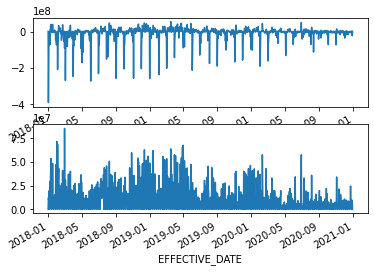

(232, 360) (232, 28)
(231, 360) (231, 28)
(505, 360) (505, 28)
(231, 360) (231, 28)
(778, 360) (778, 28)
(231, 360) (231, 28)
Branch: A2
                WEEKEND  HOLIDAY  WEEKEND_HOLIDAY  IS_SUN  IS_MON  IS_TUE  \
EFFECTIVE_DATE                                                              
2018-01-01            1        0                0       0       1       0   
2018-01-02            1        0                0       0       0       1   
2018-01-03            1        1                1       0       0       0   
2018-01-04            1        1                1       0       0       0   
2018-01-05            1        1                1       0       0       0   

                IS_WED  IS_THU  IS_FRI  IS_SAT  TOTAL_CASH_IN  TOTAL_CASH_OUT  \
EFFECTIVE_DATE                                                                  
2018-01-01           0       0       0       0           0.00            0.00   
2018-01-02           0       0       0       0           0.00            0.00   

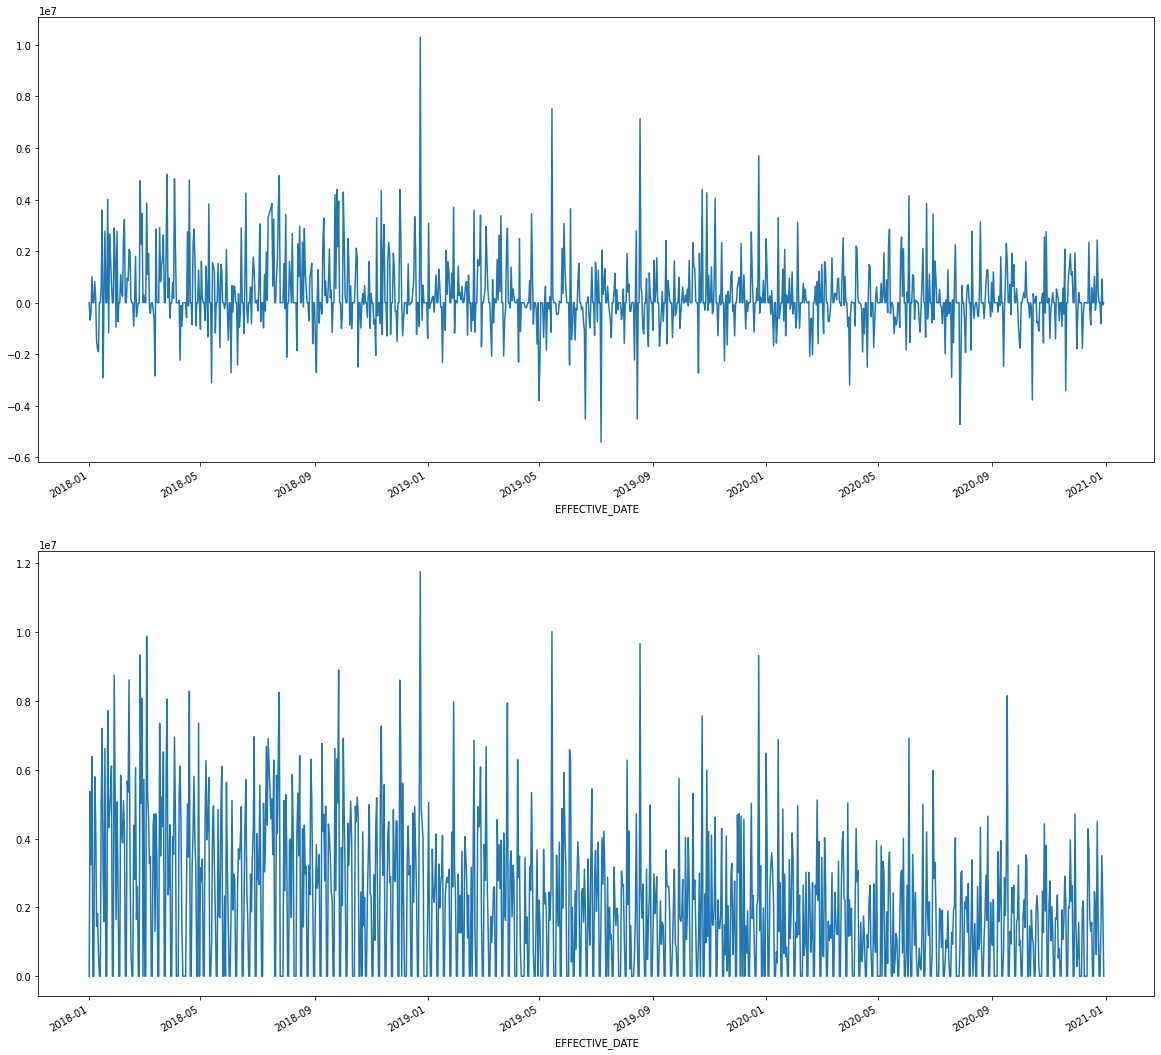

(232, 360) (232, 28)
(231, 360) (231, 28)
(505, 360) (505, 28)
(231, 360) (231, 28)
(778, 360) (778, 28)
(231, 360) (231, 28)
Branch: A3
                WEEKEND  HOLIDAY  WEEKEND_HOLIDAY  IS_SUN  IS_MON  IS_TUE  \
EFFECTIVE_DATE                                                              
2018-01-01            1        0                0       0       1       0   
2018-01-02            1        0                0       0       0       1   
2018-01-03            1        1                1       0       0       0   
2018-01-04            1        1                1       0       0       0   
2018-01-05            1        1                1       0       0       0   

                IS_WED  IS_THU  IS_FRI  IS_SAT  TOTAL_CASH_IN  TOTAL_CASH_OUT  \
EFFECTIVE_DATE                                                                  
2018-01-01           0       0       0       0           0.00            0.00   
2018-01-02           0       0       0       0           0.00            0.00   

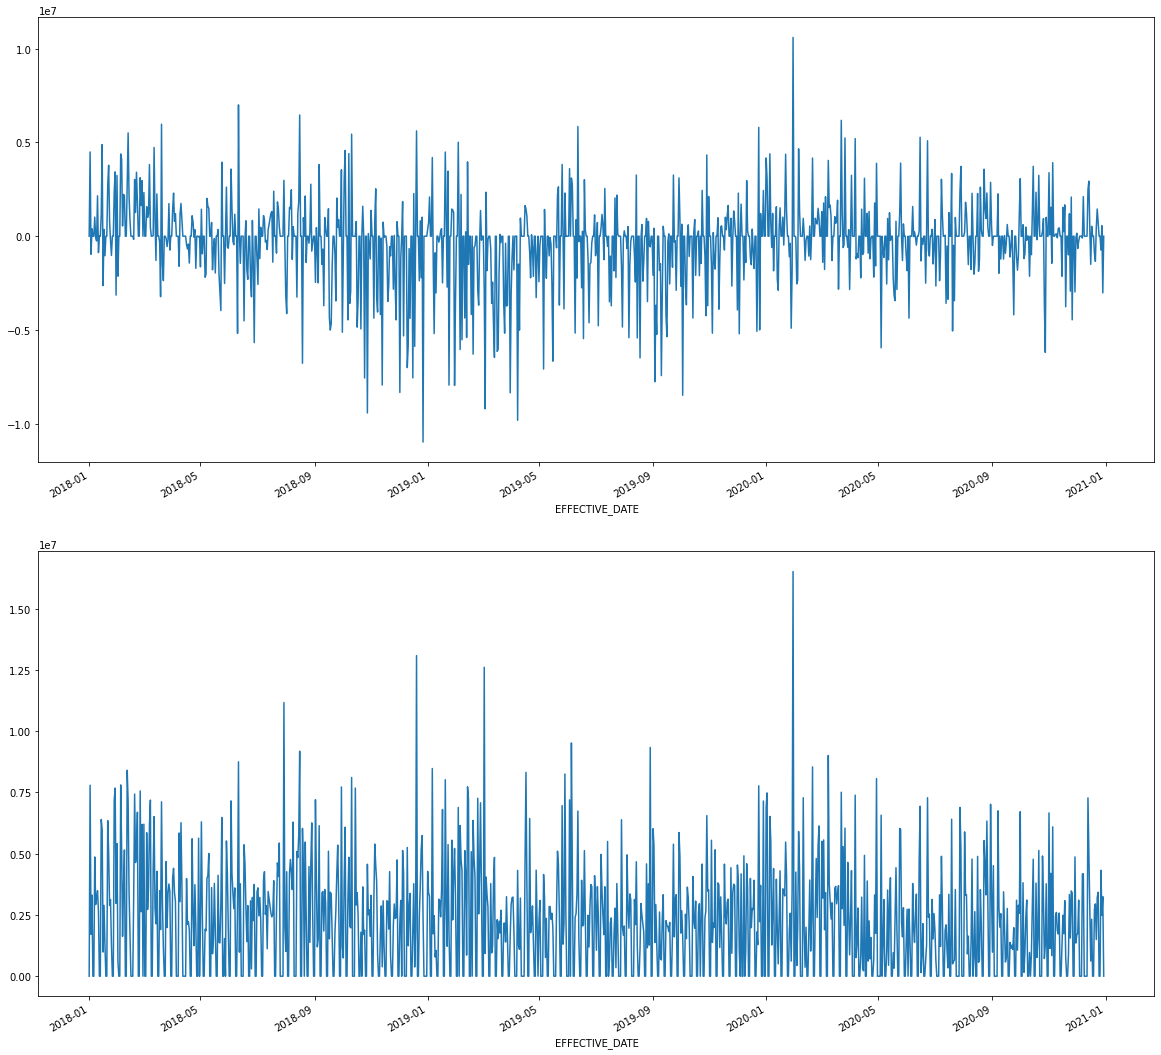

(232, 360) (232, 28)
(231, 360) (231, 28)
(505, 360) (505, 28)
(231, 360) (231, 28)
(778, 360) (778, 28)
(231, 360) (231, 28)
Branch: A4
                WEEKEND  HOLIDAY  WEEKEND_HOLIDAY  IS_SUN  IS_MON  IS_TUE  \
EFFECTIVE_DATE                                                              
2018-01-01            1        0                0       0       1       0   
2018-01-02            1        0                0       0       0       1   
2018-01-03            1        1                1       0       0       0   
2018-01-04            1        1                1       0       0       0   
2018-01-05            1        1                1       0       0       0   

                IS_WED  IS_THU  IS_FRI  IS_SAT  TOTAL_CASH_IN  TOTAL_CASH_OUT  \
EFFECTIVE_DATE                                                                  
2018-01-01           0       0       0       0           0.00            0.00   
2018-01-02           0       0       0       0           0.00            0.00   

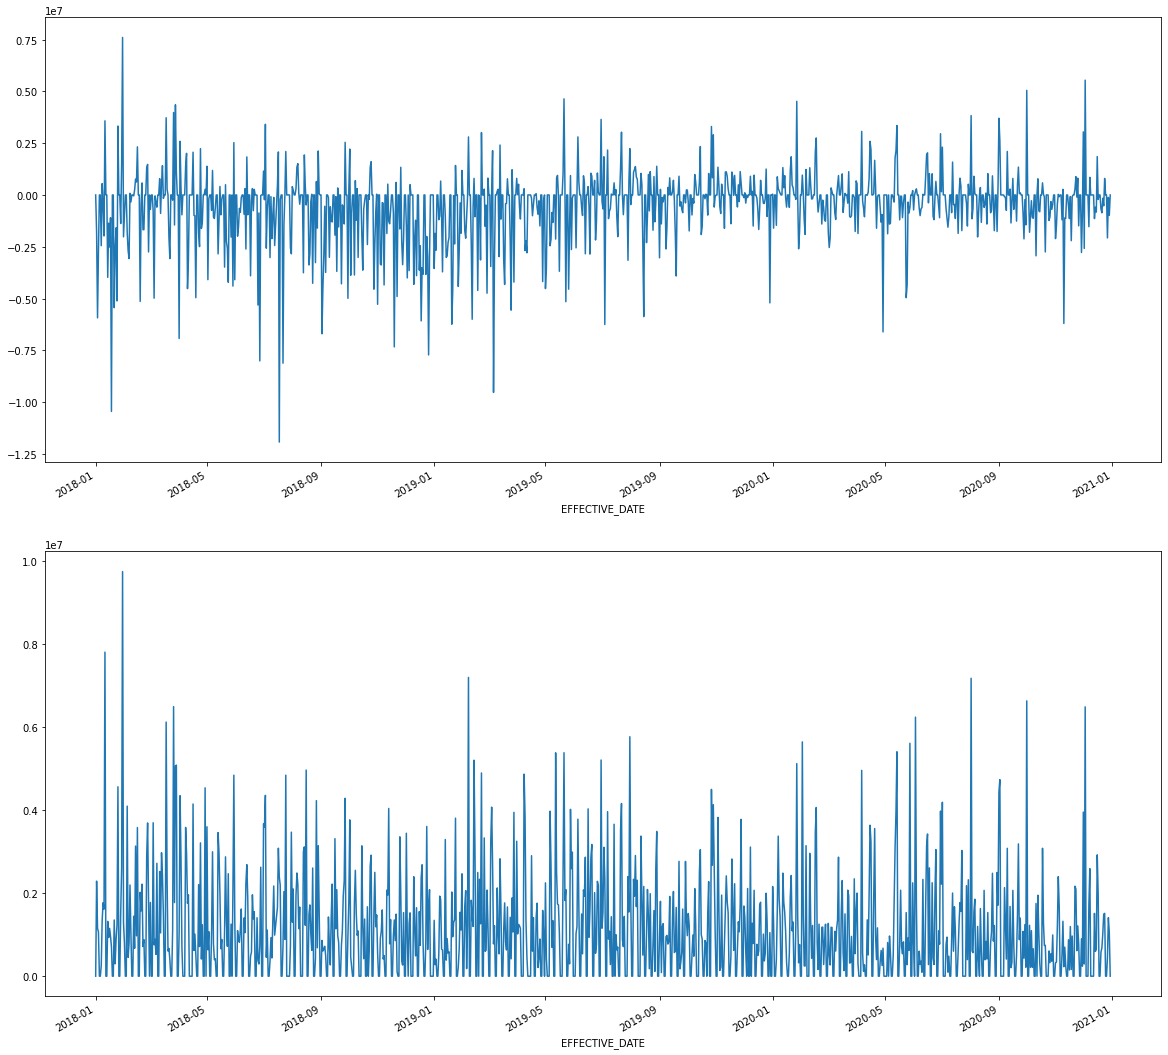

(232, 360) (232, 28)
(231, 360) (231, 28)
(505, 360) (505, 28)
(231, 360) (231, 28)
(778, 360) (778, 28)
(231, 360) (231, 28)
Branch: B1
                WEEKEND  HOLIDAY  WEEKEND_HOLIDAY  IS_SUN  IS_MON  IS_TUE  \
EFFECTIVE_DATE                                                              
2018-01-01            1        0                0       0       1       0   
2018-01-02            1        0                0       0       0       1   
2018-01-03            1        1                1       0       0       0   
2018-01-04            1        1                1       0       0       0   
2018-01-05            1        1                1       0       0       0   

                IS_WED  IS_THU  IS_FRI  IS_SAT  TOTAL_CASH_IN  TOTAL_CASH_OUT  \
EFFECTIVE_DATE                                                                  
2018-01-01           0       0       0       0           0.00            0.00   
2018-01-02           0       0       0       0     1935892.50      2617964.04   

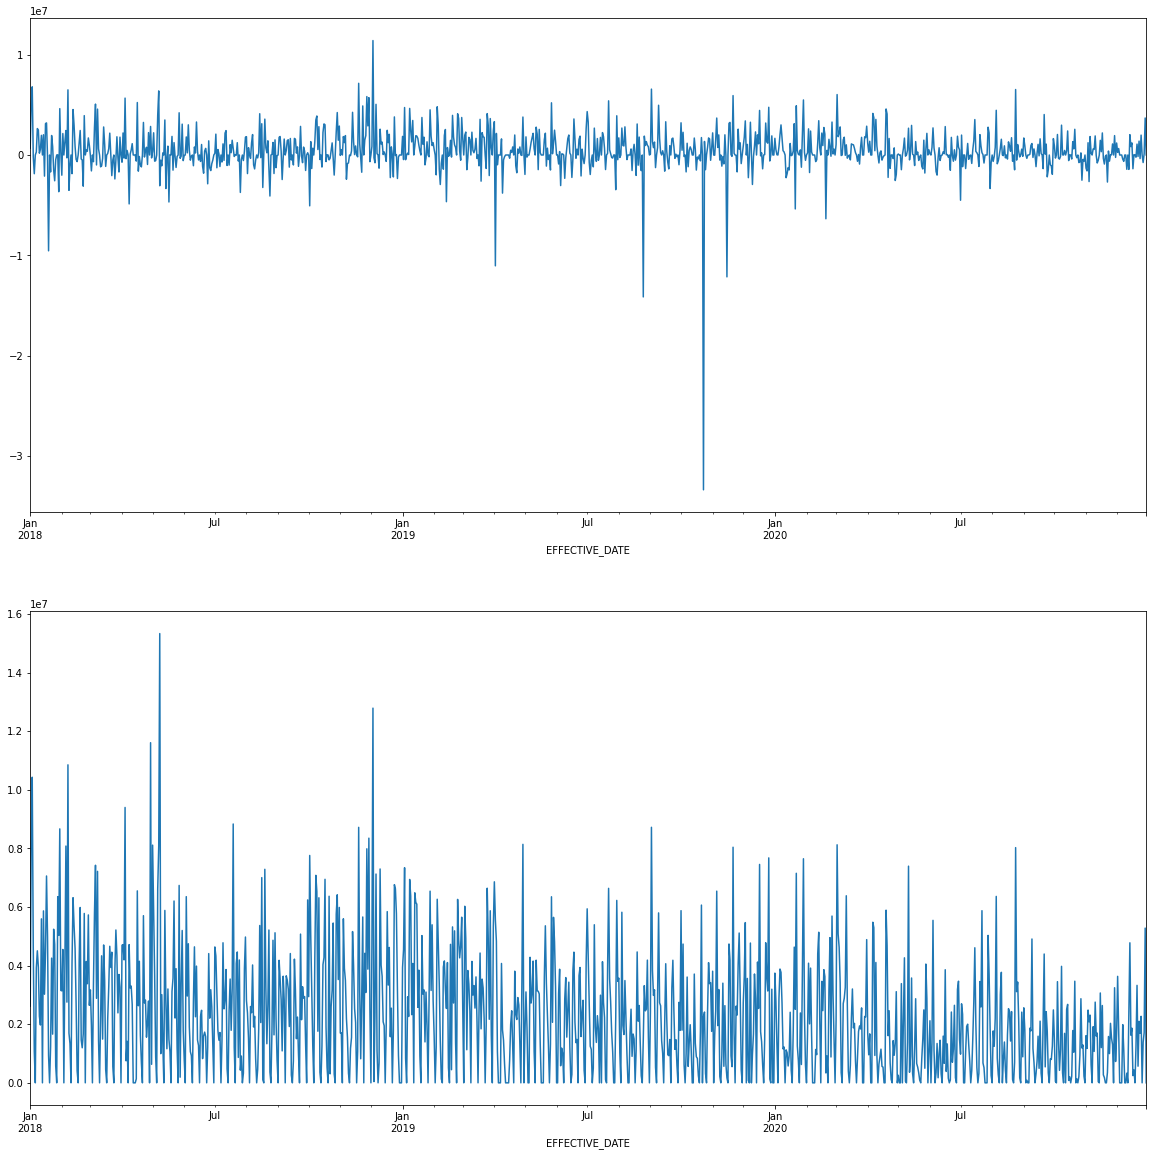

(234, 360) (234, 28)
(231, 360) (231, 28)
(507, 360) (507, 28)
(231, 360) (231, 28)
(780, 360) (780, 28)
(231, 360) (231, 28)
Branch: B2
                WEEKEND  HOLIDAY  WEEKEND_HOLIDAY  IS_SUN  IS_MON  IS_TUE  \
EFFECTIVE_DATE                                                              
2018-01-01            1        0                0       0       1       0   
2018-01-02            1        0                0       0       0       1   
2018-01-03            1        1                1       0       0       0   
2018-01-04            1        1                1       0       0       0   
2018-01-05            1        1                1       0       0       0   

                IS_WED  IS_THU  IS_FRI  IS_SAT  TOTAL_CASH_IN  TOTAL_CASH_OUT  \
EFFECTIVE_DATE                                                                  
2018-01-01           0       0       0       0           0.00            0.00   
2018-01-02           0       0       0       0           0.00            0.00   

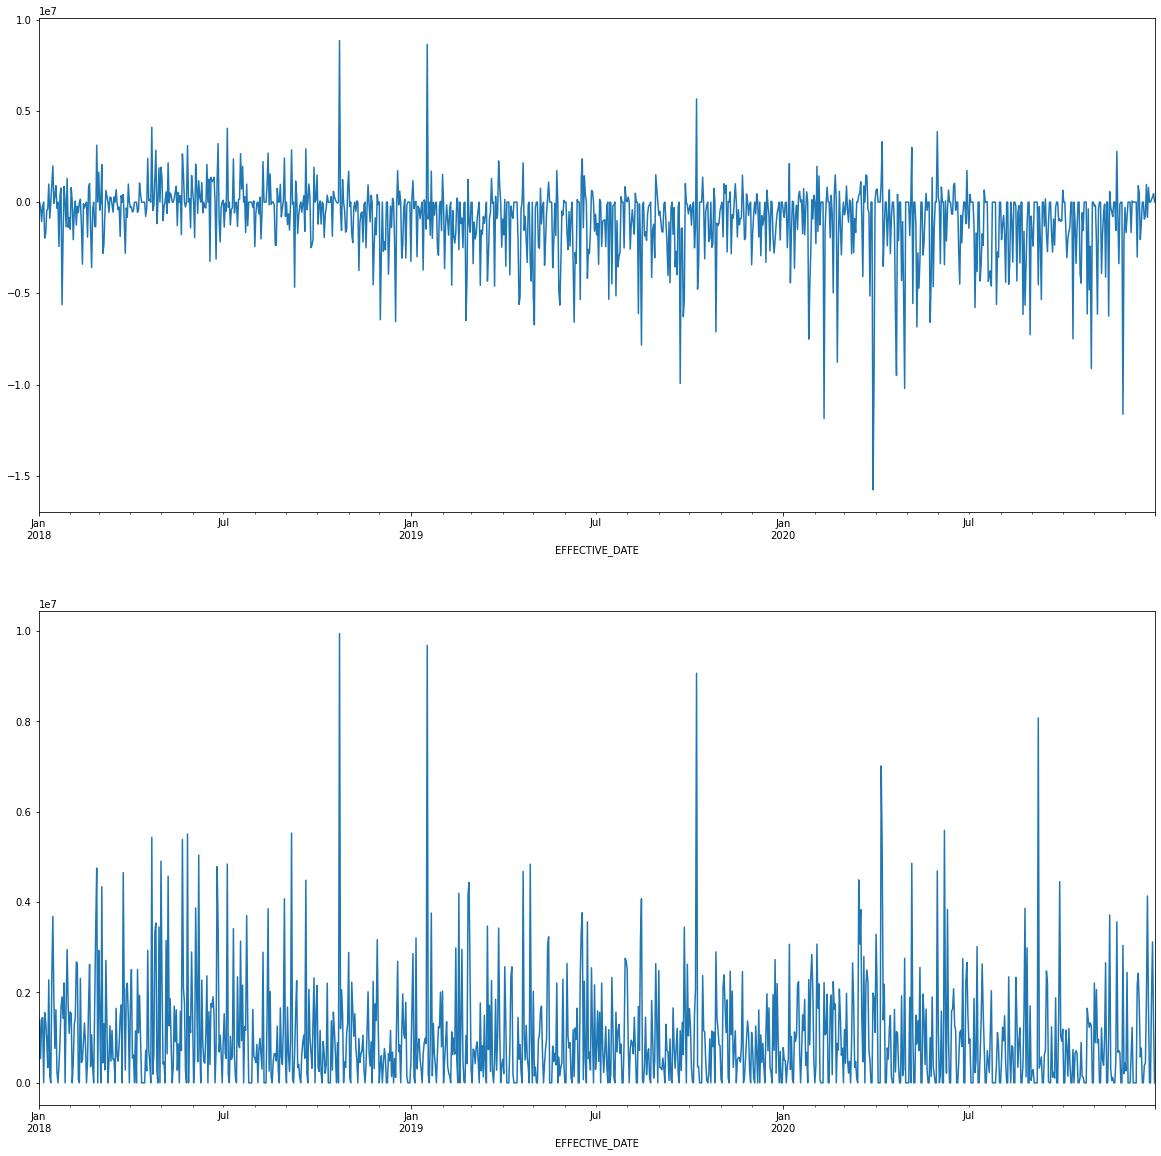

(234, 360) (234, 28)
(231, 360) (231, 28)
(507, 360) (507, 28)
(231, 360) (231, 28)
(780, 360) (780, 28)
(231, 360) (231, 28)
Branch: C1
                WEEKEND  HOLIDAY  WEEKEND_HOLIDAY  IS_SUN  IS_MON  IS_TUE  \
EFFECTIVE_DATE                                                              
2018-01-01            1        0                0       0       1       0   
2018-01-02            1        0                0       0       0       1   
2018-01-03            1        1                1       0       0       0   
2018-01-04            1        1                1       0       0       0   
2018-01-05            1        1                1       0       0       0   

                IS_WED  IS_THU  IS_FRI  IS_SAT  TOTAL_CASH_IN  TOTAL_CASH_OUT  \
EFFECTIVE_DATE                                                                  
2018-01-01           0       0       0       0           0.00            0.00   
2018-01-02           0       0       0       0    15894599.25     12808409.49   

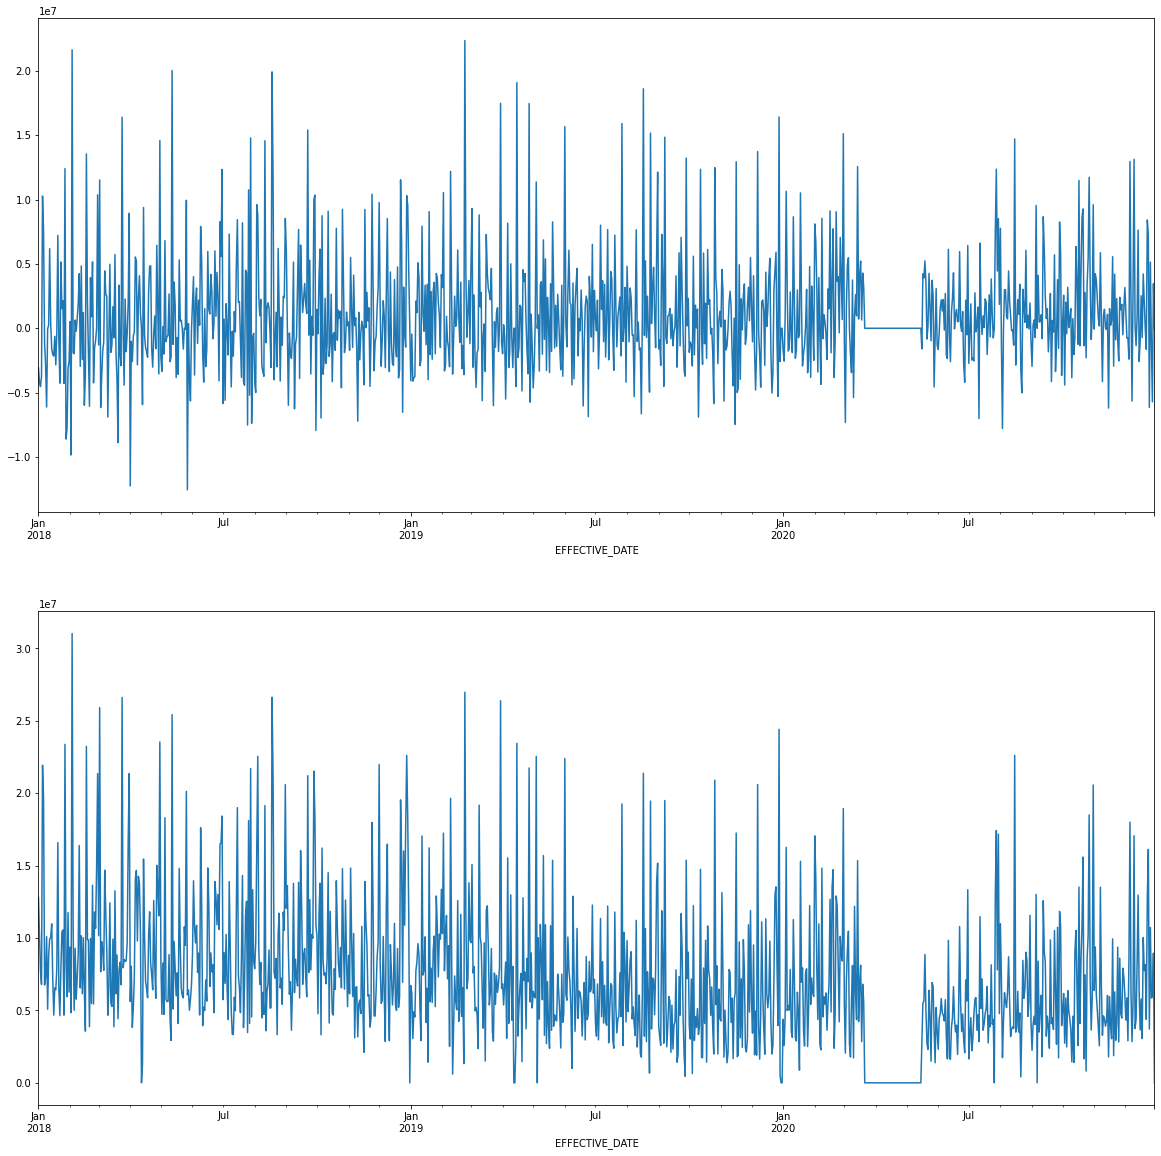

(234, 360) (234, 28)
(231, 360) (231, 28)
(507, 360) (507, 28)
(231, 360) (231, 28)
(780, 360) (780, 28)
(231, 360) (231, 28)
Branch: C2
                WEEKEND  HOLIDAY  WEEKEND_HOLIDAY  IS_SUN  IS_MON  IS_TUE  \
EFFECTIVE_DATE                                                              
2018-01-01            1        0                0       0       1       0   
2018-01-02            1        0                0       0       0       1   
2018-01-03            1        1                1       0       0       0   
2018-01-04            1        1                1       0       0       0   
2018-01-05            1        1                1       0       0       0   

                IS_WED  IS_THU  IS_FRI  IS_SAT  TOTAL_CASH_IN  TOTAL_CASH_OUT  \
EFFECTIVE_DATE                                                                  
2018-01-01           0       0       0       0           0.00       554887.21   
2018-01-02           0       0       0       0           0.00      1037637.66   

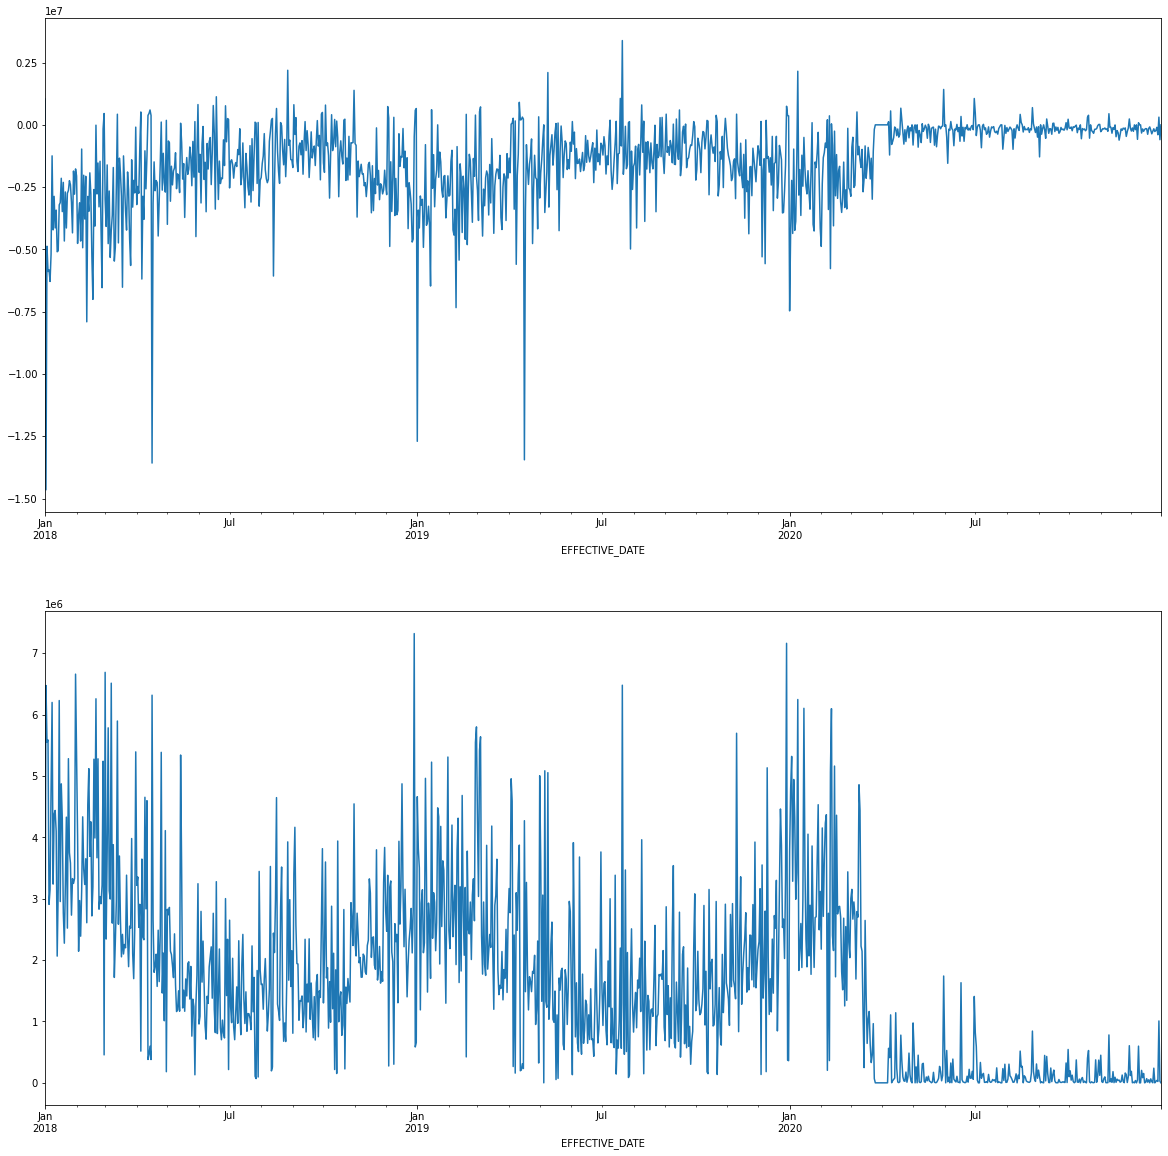

(234, 360) (234, 28)
(231, 360) (231, 28)
(507, 360) (507, 28)
(231, 360) (231, 28)
(780, 360) (780, 28)
(231, 360) (231, 28)
Branch: C3
                WEEKEND  HOLIDAY  WEEKEND_HOLIDAY  IS_SUN  IS_MON  IS_TUE  \
EFFECTIVE_DATE                                                              
2018-01-01            1        0                0       0       1       0   
2018-01-02            1        0                0       0       0       1   
2018-01-03            1        1                1       0       0       0   
2018-01-04            1        1                1       0       0       0   
2018-01-05            1        1                1       0       0       0   

                IS_WED  IS_THU  IS_FRI  IS_SAT  TOTAL_CASH_IN  TOTAL_CASH_OUT  \
EFFECTIVE_DATE                                                                  
2018-01-01           0       0       0       0           0.00            0.00   
2018-01-02           0       0       0       0     4016698.75      3031235.26   

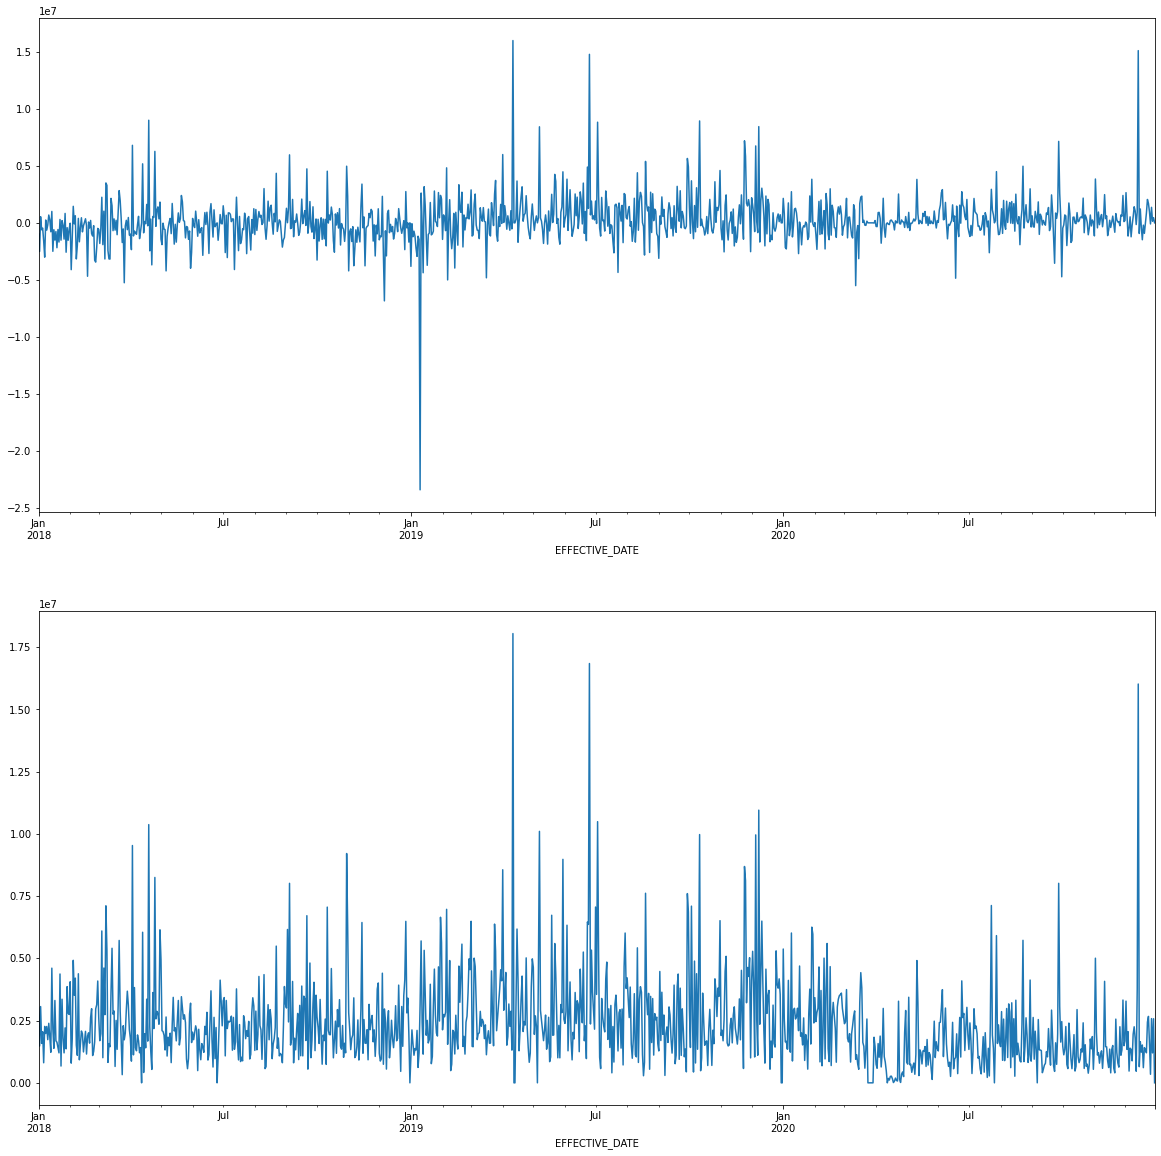

(234, 360) (234, 28)
(231, 360) (231, 28)
(507, 360) (507, 28)
(231, 360) (231, 28)
(780, 360) (780, 28)
(231, 360) (231, 28)
Branch: C4
                WEEKEND  HOLIDAY  WEEKEND_HOLIDAY  IS_SUN  IS_MON  IS_TUE  \
EFFECTIVE_DATE                                                              
2018-01-01            1        0                0       0       1       0   
2018-01-02            1        0                0       0       0       1   
2018-01-03            1        1                1       0       0       0   
2018-01-04            1        1                1       0       0       0   
2018-01-05            1        1                1       0       0       0   

                IS_WED  IS_THU  IS_FRI  IS_SAT  TOTAL_CASH_IN  TOTAL_CASH_OUT  \
EFFECTIVE_DATE                                                                  
2018-01-01           0       0       0       0           0.00            0.00   
2018-01-02           0       0       0       0    10813325.02     17177246.92   

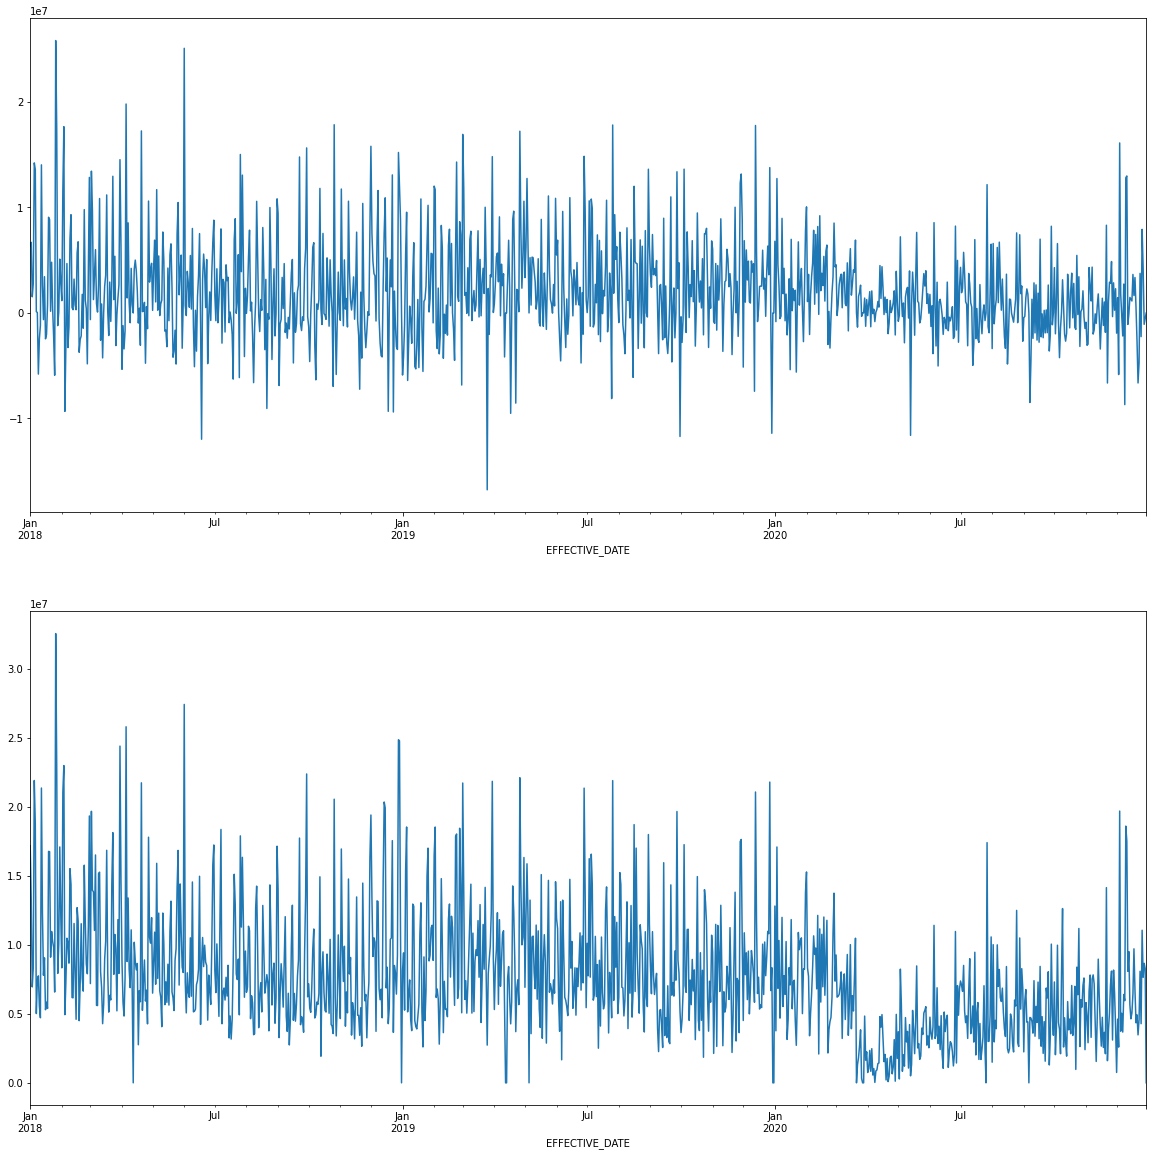

(234, 360) (234, 28)
(231, 360) (231, 28)
(507, 360) (507, 28)
(231, 360) (231, 28)
(780, 360) (780, 28)
(231, 360) (231, 28)


In [15]:
for branch_id in BRANCHES_ALL:  
    print(f'Branch: {branch_id}')
    directory = os.path.join("/home/wachi/Desktop/bank/", branch_id)
    os.chdir(directory)
    predict_COCI_CO(branch_id)
    os.chdir("..")